In [89]:
%matplotlib inline
import quandl, math
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from tsmom_model import *
import numpy as np
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

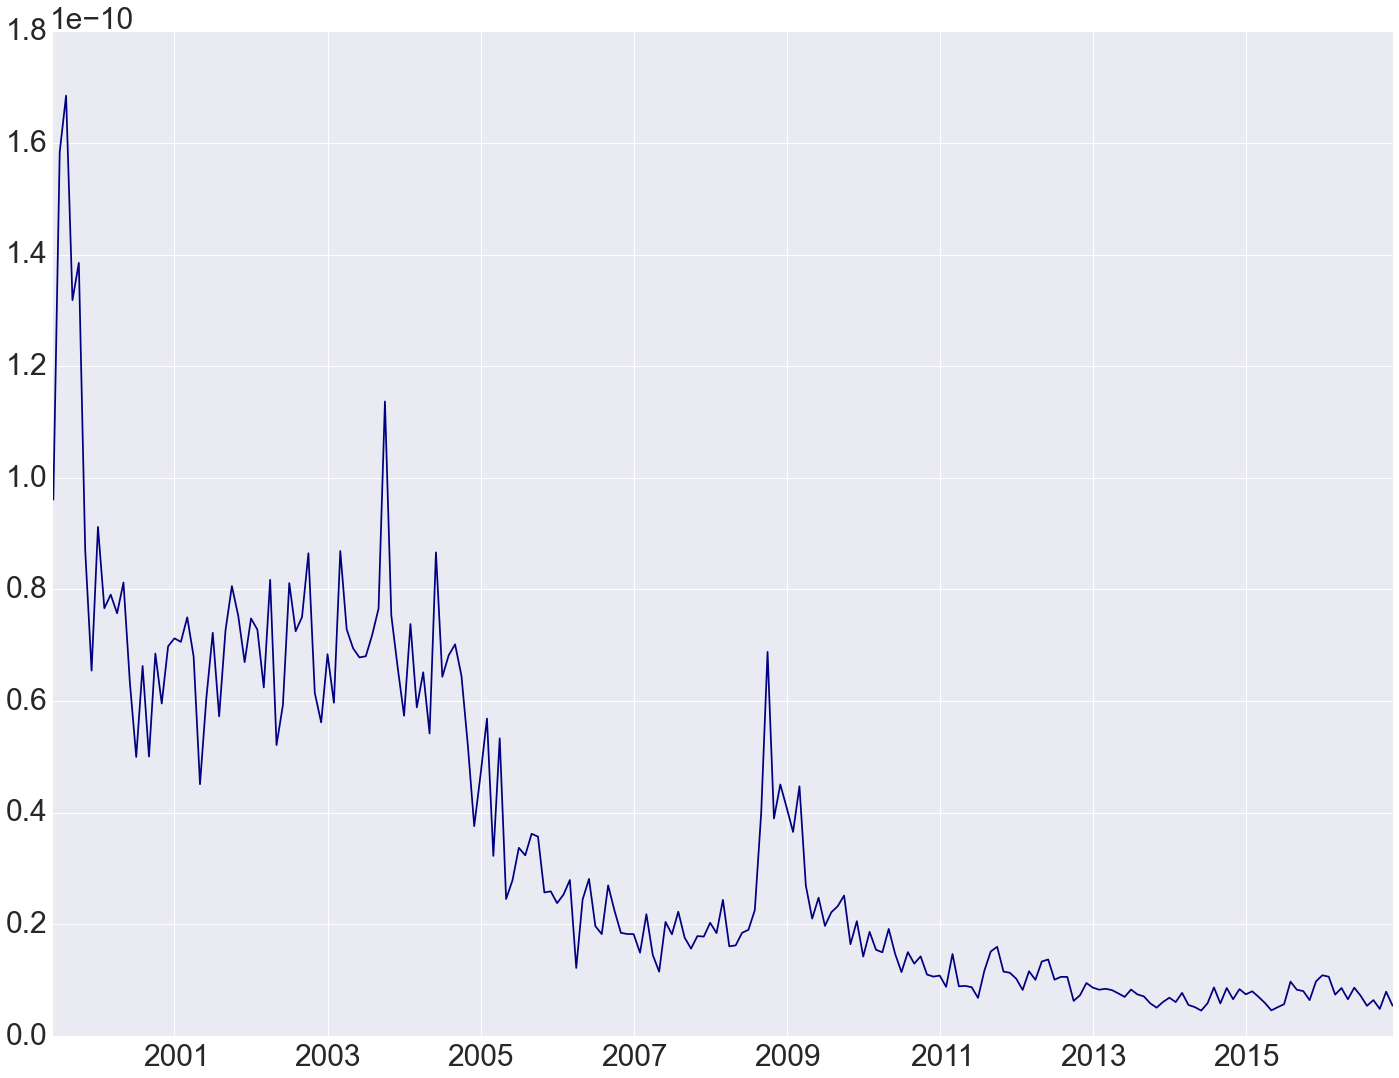

In [90]:
cleansed=load_amihud_markets_price()
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 
amihud.median(axis=1).dropna().plot(colormap='jet')

# When is liquidity not liquidity

In [91]:
vol=load_daily_volume()

In [92]:
sp500='CME-MINI S&P 500 INDEX'
SP=pd.DataFrame()
SP['Price Change']=cleansed[sp500].resample(rule='m',how='last').dropna().pct_change()
SP['Volume']=vol[sp500].resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


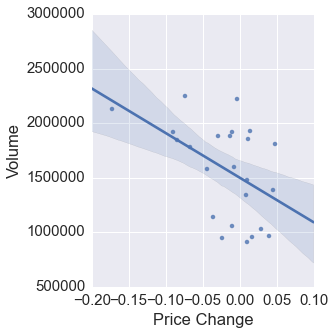

In [93]:
sns.set(font_scale=1.5)
sns.lmplot('Price Change','Volume',SP['2007':'2008'])


In [122]:
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Bank of International Settlement 
 * Turnover and Open Interest in exchange traded futures
 * Global data on all futures contracts
 * Problem this data only goes to 2012
 * Quarterly data

In [123]:
futures=pd.DataFrame()
futures['OI']=quandl.get('BIS/EXCHDERIV_0',authtoken=token)['USD Billions']
futures['Turnover']=quandl.get('BIS/EXCHDERIV_32',authtoken=token)['USD Billions']

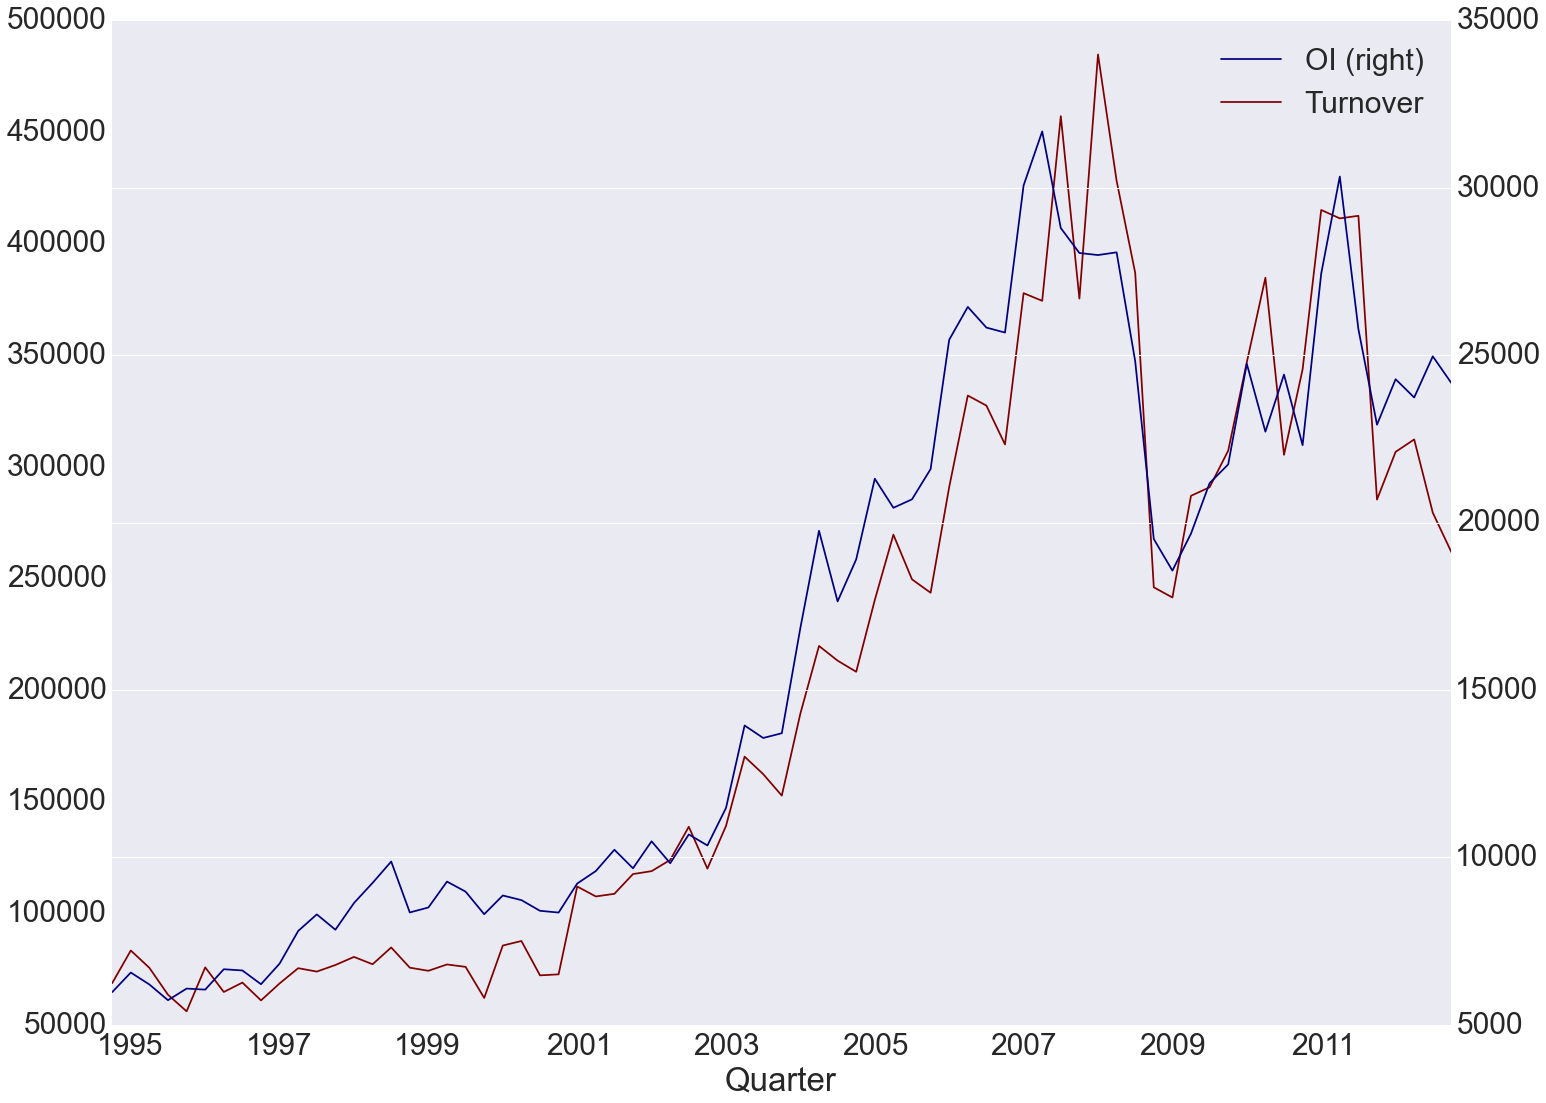

In [124]:
futures.plot(secondary_y='OI',colormap='jet')

In [125]:
mkt_liquidity=amihud.median(axis=1).dropna()
total_AUM=etf[etf_list].sum(axis=1).resample(rule='m')
ind=futures.index
ex=pd.DataFrame()
ex['Amihud']=mkt_liquidity[ind]
ex['OI']=futures.OI
ex['Turnover']=futures.Turnover
ex['Intercept']=1
ex=ex.dropna()
res1=sm.OLS(ex.Amihud,ex[['Intercept','OI']]).fit()
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     120.7
Date:                Thu, 31 Aug 2017   Prob (F-statistic):           2.85e-15
Time:                        19:33:07   Log-Likelihood:                 1291.0
No. Observations:                  55   AIC:                            -2578.
Df Residuals:                      53   BIC:                            -2574.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.041e-10   6.01e-12     17.306      0.0

In [126]:
res2=sm.OLS(ex.Amihud,ex[['Intercept','Turnover']]).fit()
print res2.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     105.3
Date:                Thu, 31 Aug 2017   Prob (F-statistic):           3.38e-14
Time:                        19:33:07   Log-Likelihood:                 1288.5
No. Observations:                  55   AIC:                            -2573.
Df Residuals:                      53   BIC:                            -2569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.058e-11   5.21e-12     17.394      0.0

In [127]:
tab=pd.DataFrame()
for c in ['OI','Turnover']:
    res=sm.OLS(ex.Amihud,ex[['Intercept',c]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept*1e10
    s['Intercept T']=res.tvalues.Intercept
    s['Arg']=res.params[c]*1e10
    s['T']=res.tvalues[c]
    s['R^2']=res.rsquared_adj
    tab[c]=s   

In [128]:
tab

,OI,Turnover
Intercept,1.040527,0.905848
Intercept T,17.305797,17.394230
Arg,-0.000032,-0.000002
T,-10.984787,-10.262343
R^2,0.689058,0.658909


In [129]:
print tab.to_latex()

\begin{tabular}{lrr}
\toprule
{} &         OI &   Turnover \\
\midrule
Intercept   &   1.040527 &   0.905848 \\
Intercept T &  17.305797 &  17.394230 \\
Arg         &  -0.000032 &  -0.000002 \\
T           & -10.984787 & -10.262343 \\
R\textasciicircum2         &   0.689058 &   0.658909 \\
\bottomrule
\end{tabular}



# Largest ETF data for Commodity 
 * Source: CRSP
 * Using the largest ETN funds that trade commodity futures to determine the rough size of the industry and see if the AUM in these ETF drive the liquidity in the market
 * Somthing is wrong with OIL and DJP

In [151]:
data=pd.read_csv('ETF_Price.csv',parse_dates=['date'])
etf_list=['USO','DBA','DBC','UCO','GSG']
etf=pd.DataFrame()
for e in etf_list:
    x=data[data.TICKER==e].set_index('date')
    etf[e]=x.PRC * x.SHROUT


In [152]:
mkt_liquidity=amihud.median(axis=1).dropna()
total_AUM=etf[etf_list].sum(axis=1).resample(rule='m')
ind=total_AUM[:'2016'].index
ex=pd.DataFrame()
ex['Amihud']=mkt_liquidity[ind]
ex['ETF AUM']=total_AUM[:'2016']
ex['Intercept']=1
res=sm.OLS(ex.Amihud,ex[['Intercept','ETF AUM']]).fit()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


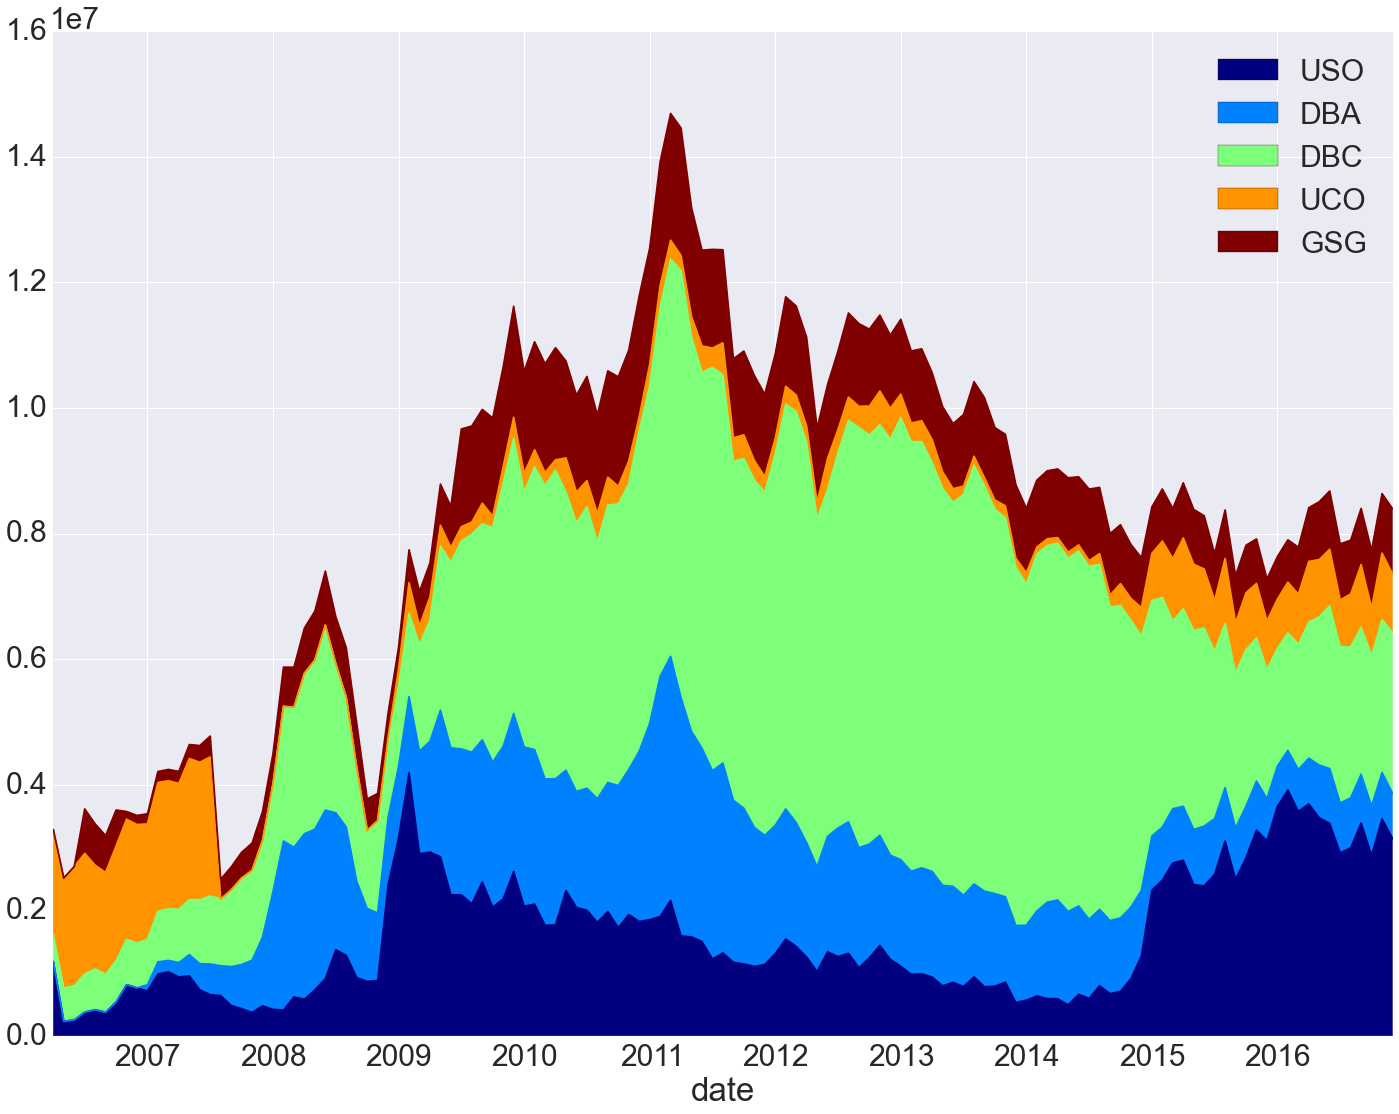

In [132]:
etf['2000':].dropna(how='all').resample(rule='m').plot(colormap='jet',kind='area',stacked=True)

In [133]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 31 Aug 2017   Prob (F-statistic):                nan
Time:                        19:33:11   Log-Likelihood:                    nan
No. Observations:                 268   AIC:                               nan
Df Residuals:                     268   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept         nan        nan        nan        n

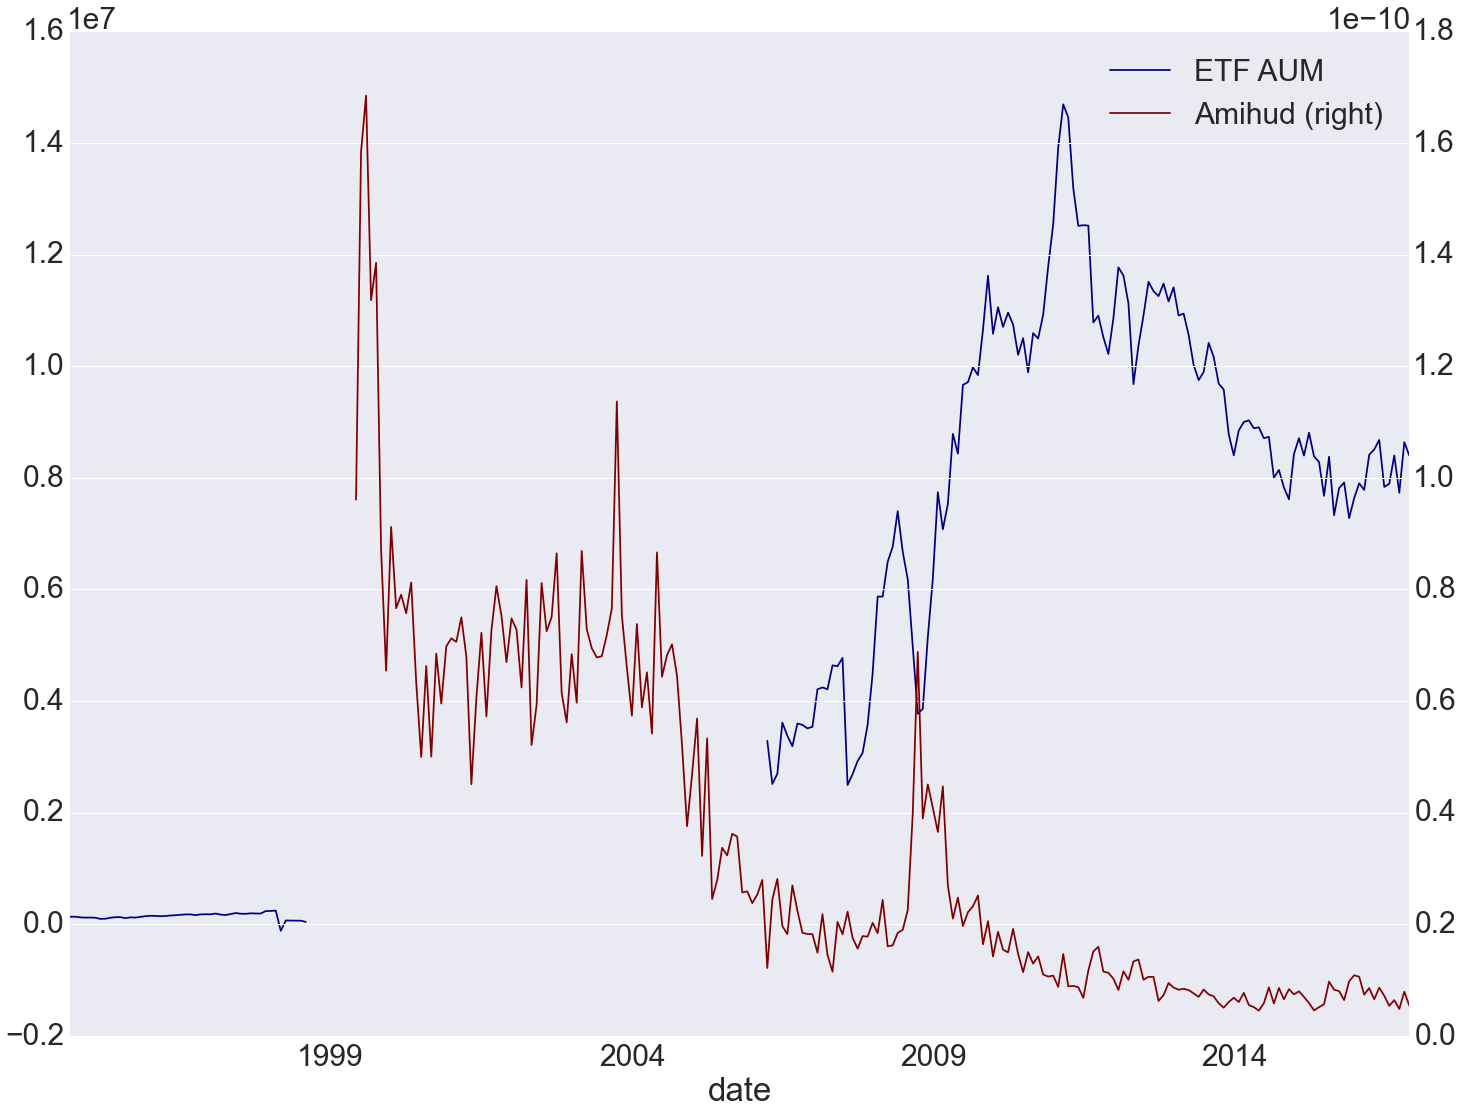

In [134]:
ex[['ETF AUM','Amihud']].plot(secondary_y='Amihud',colormap='jet')

#Hedge Fund Index
    Credit Suisse Alt Beta indices

In [135]:
cs_data=pd.read_csv('CS_AltBeta.csv',parse_dates=['Date'],index_col=[0])

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


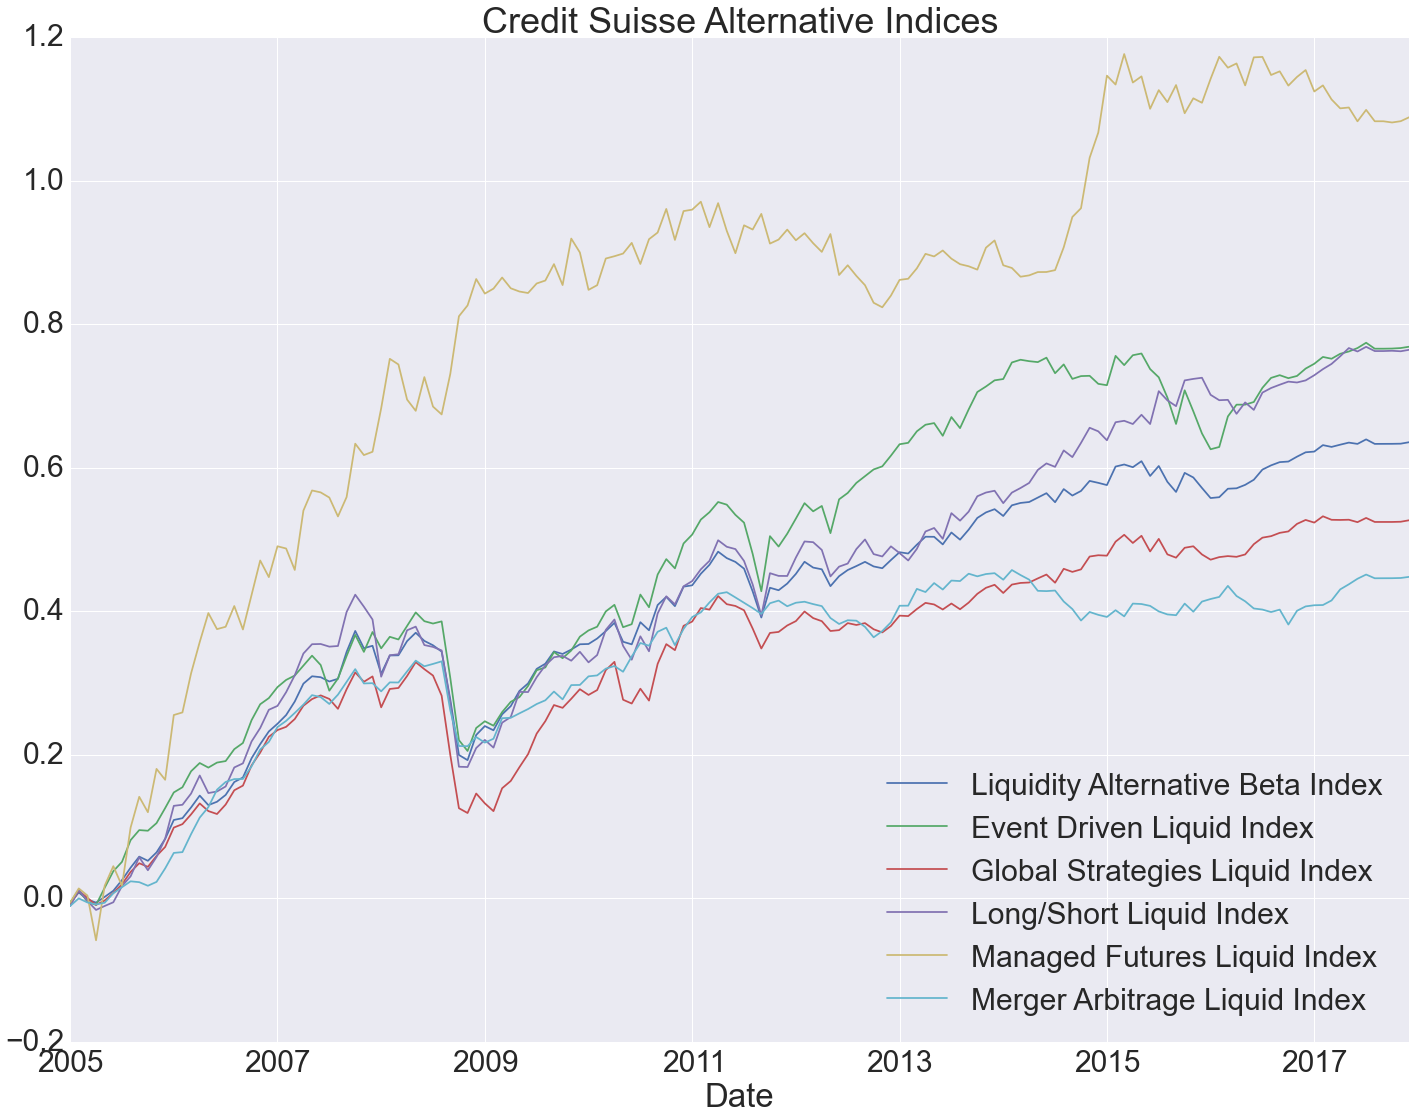

In [136]:
cs_data['2005':].dropna().cumsum().resample(rule='m',how='last').plot(title='Credit Suisse Alternative Indices')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


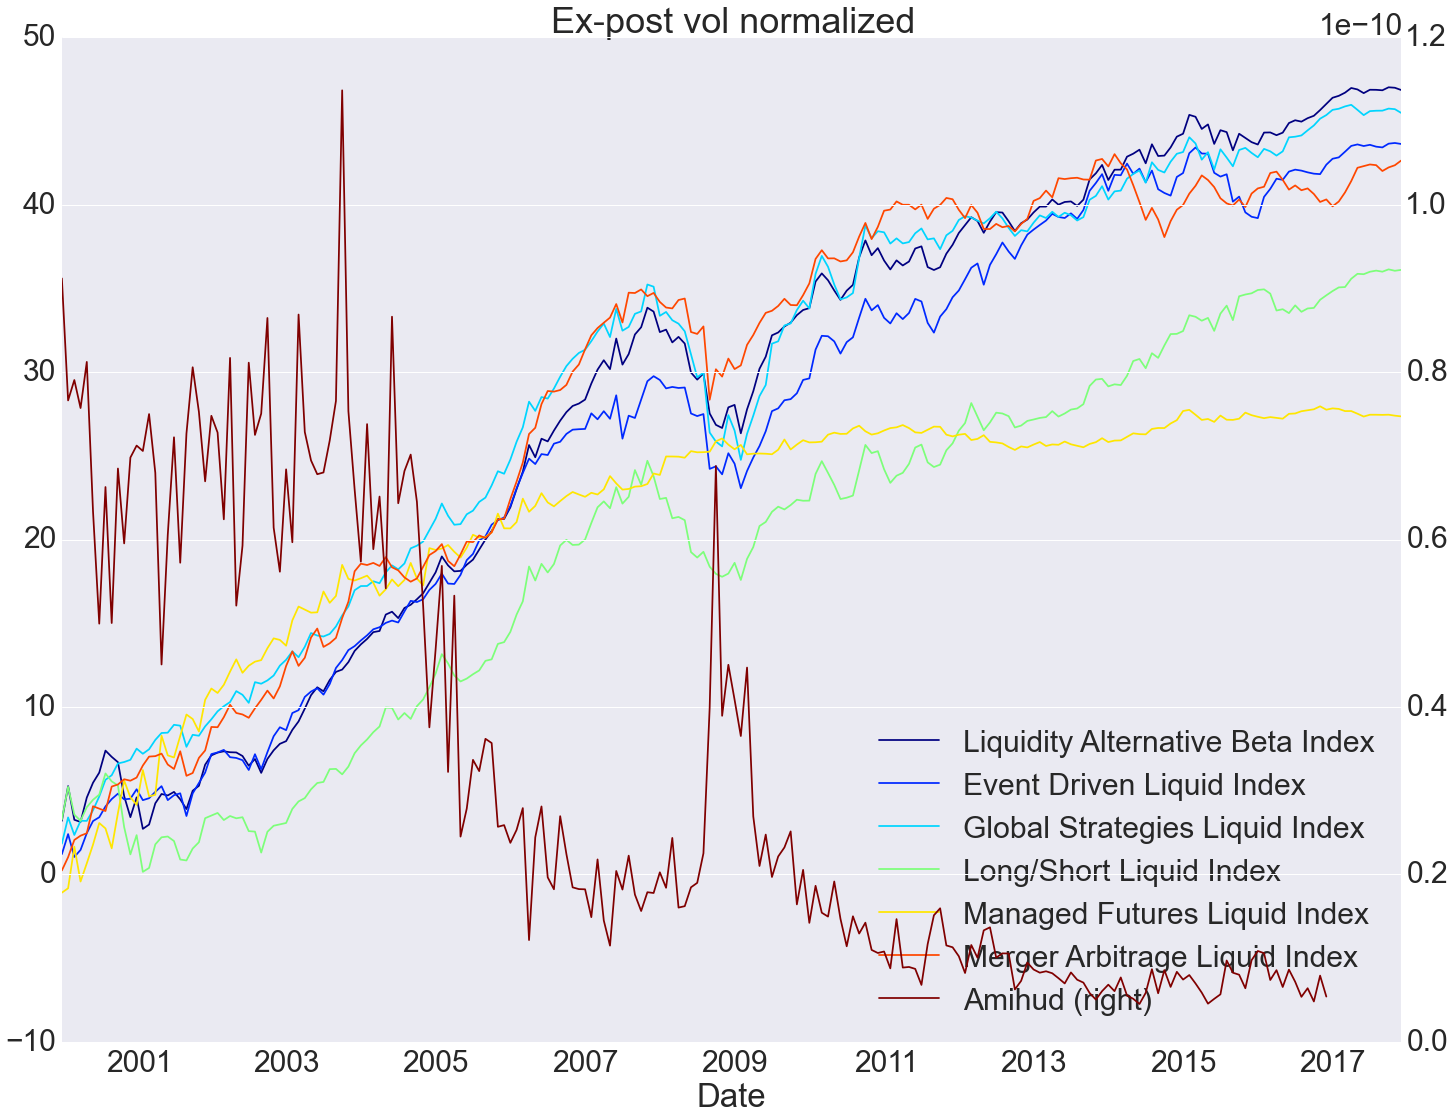

In [137]:
cs_month=cs_data.dropna().resample(rule='m',how='sum')
x=(cs_month/cs_month.diff().std()).cumsum()
x['Amihud']=amihud.median(axis=1).dropna()
x.plot(title='Ex-post vol normalized',secondary_y='Amihud',colormap='jet')

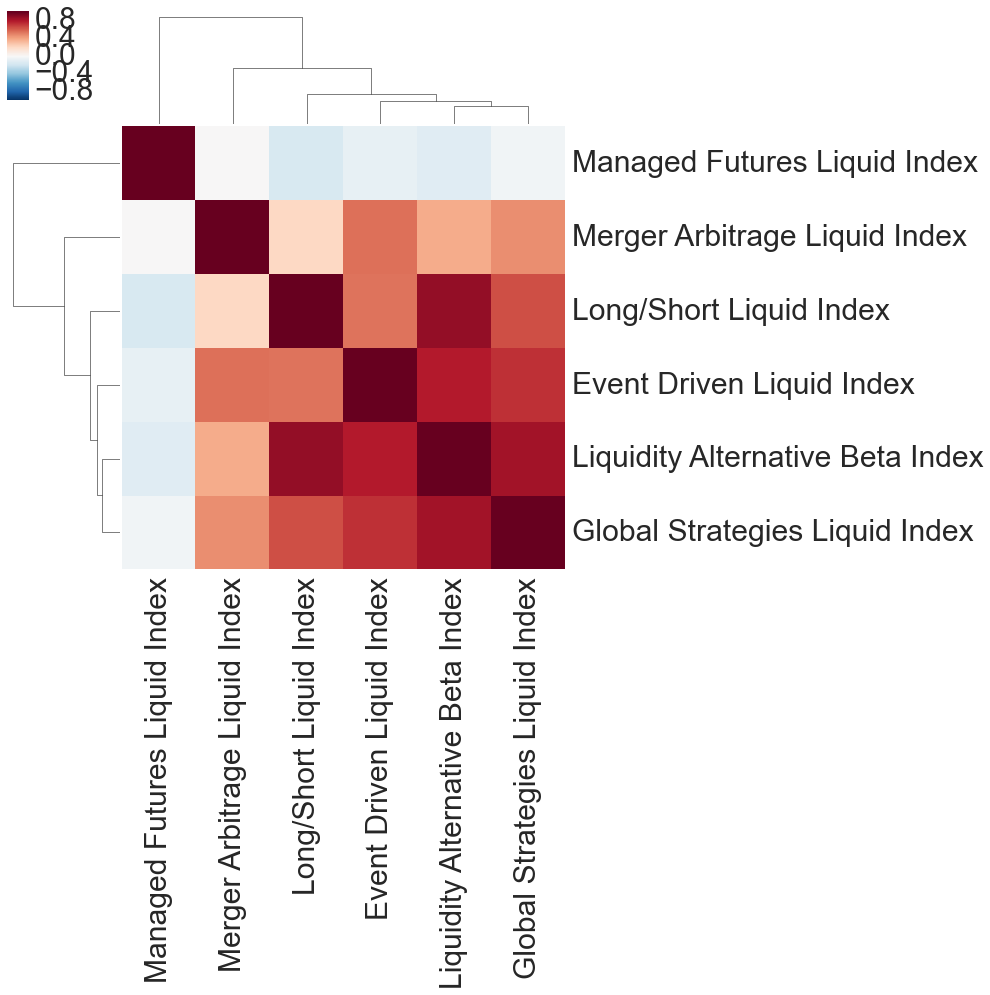

In [138]:
sns.clustermap(cs_month.diff().corr())

In [139]:
cs_month=cs_data.dropna().cumsum().resample(rule='m',how='last').pct_change()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [140]:
mkt_liquidity=amihud.median(axis=1).dropna().diff()
ind_res2 = pd.DataFrame()
for c in cs_month.columns:
    s=pd.Series()
    ind=cs_month[c].dropna()['2000':'2016'].index
    ex=pd.DataFrame()
    ex['Amihud']=mkt_liquidity[ind]
    ex['Intercept']=1
    res=sm.OLS(cs_month[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Amihud (x1e-9)']=res.params.Amihud/1e9
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res2[c]=s

In [141]:
ind_res2.round(2)

,Liquidity Alternative Beta Index,Event Driven Liquid Index,Global Strategies Liquid Index,Long/Short Liquid Index,Managed Futures Liquid Index,Merger Arbitrage Liquid Index
Intercept,-2.02,0.02,0.03,-0.16,0.04,0.02
Intercept Tstat,-0.93,2.32,1.90,-1.32,2.04,2.58
Amihud (x1e-9),321.68,-2.72,-2.96,25.78,0.91,-1.95
Amihud Tstat,1.45,-2.50,-1.88,2.13,0.50,-2.20
Adj R^2,0.01,0.03,0.01,0.02,-0.00,0.02


In [142]:
print ind_res2.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Liquidity Alternative Beta Index &  Event Driven Liquid Index &  Global Strategies Liquid Index &  Long/Short Liquid Index &  Managed Futures Liquid Index &  Merger Arbitrage Liquid Index \\
\midrule
Intercept       &                             -2.02 &                       0.02 &                            0.03 &                    -0.16 &                          0.04 &                           0.02 \\
Intercept Tstat &                             -0.93 &                       2.32 &                            1.90 &                    -1.32 &                          2.04 &                           2.58 \\
Amihud (x1e-9)  &                            321.68 &                      -2.72 &                           -2.96 &                    25.78 &                          0.91 &                          -1.95 \\
Amihud Tstat    &                              1.45 &                      -2.50 &                           -1.88 &              

Uses absolute value to determine the value if it is rising or falling

In [143]:
mkt_liquidity=amihud.median(axis=1).dropna().diff()
mkt_liquidity=(mkt_liquidity/mkt_liquidity.abs()+1)/2
ind_res2 = pd.DataFrame()
for c in cs_month.columns:
    s=pd.Series()
    ind=cs_month[c].dropna()['2000':'2016'].index
    ex=pd.DataFrame()
    ex['Amihud']=mkt_liquidity[ind]
    ex['Intercept']=1
    res=sm.OLS(cs_month[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Falling liquiditiy Indicator']=res.params.Amihud
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res2[c]=s

In [144]:
ind_res2.round(2)

,Liquidity Alternative Beta Index,Event Driven Liquid Index,Global Strategies Liquid Index,Long/Short Liquid Index,Managed Futures Liquid Index,Merger Arbitrage Liquid Index
Intercept,-4.03,0.04,0.05,-0.30,0.02,0.03
Intercept Tstat,-1.36,2.89,2.35,-1.85,0.77,2.76
Falling liquiditiy Indicator,4.06,-0.04,-0.04,0.29,0.04,-0.02
Amihud Tstat,0.93,-1.65,-1.33,1.22,1.05,-1.20
Adj R^2,-0.00,0.01,0.00,0.00,0.00,0.00


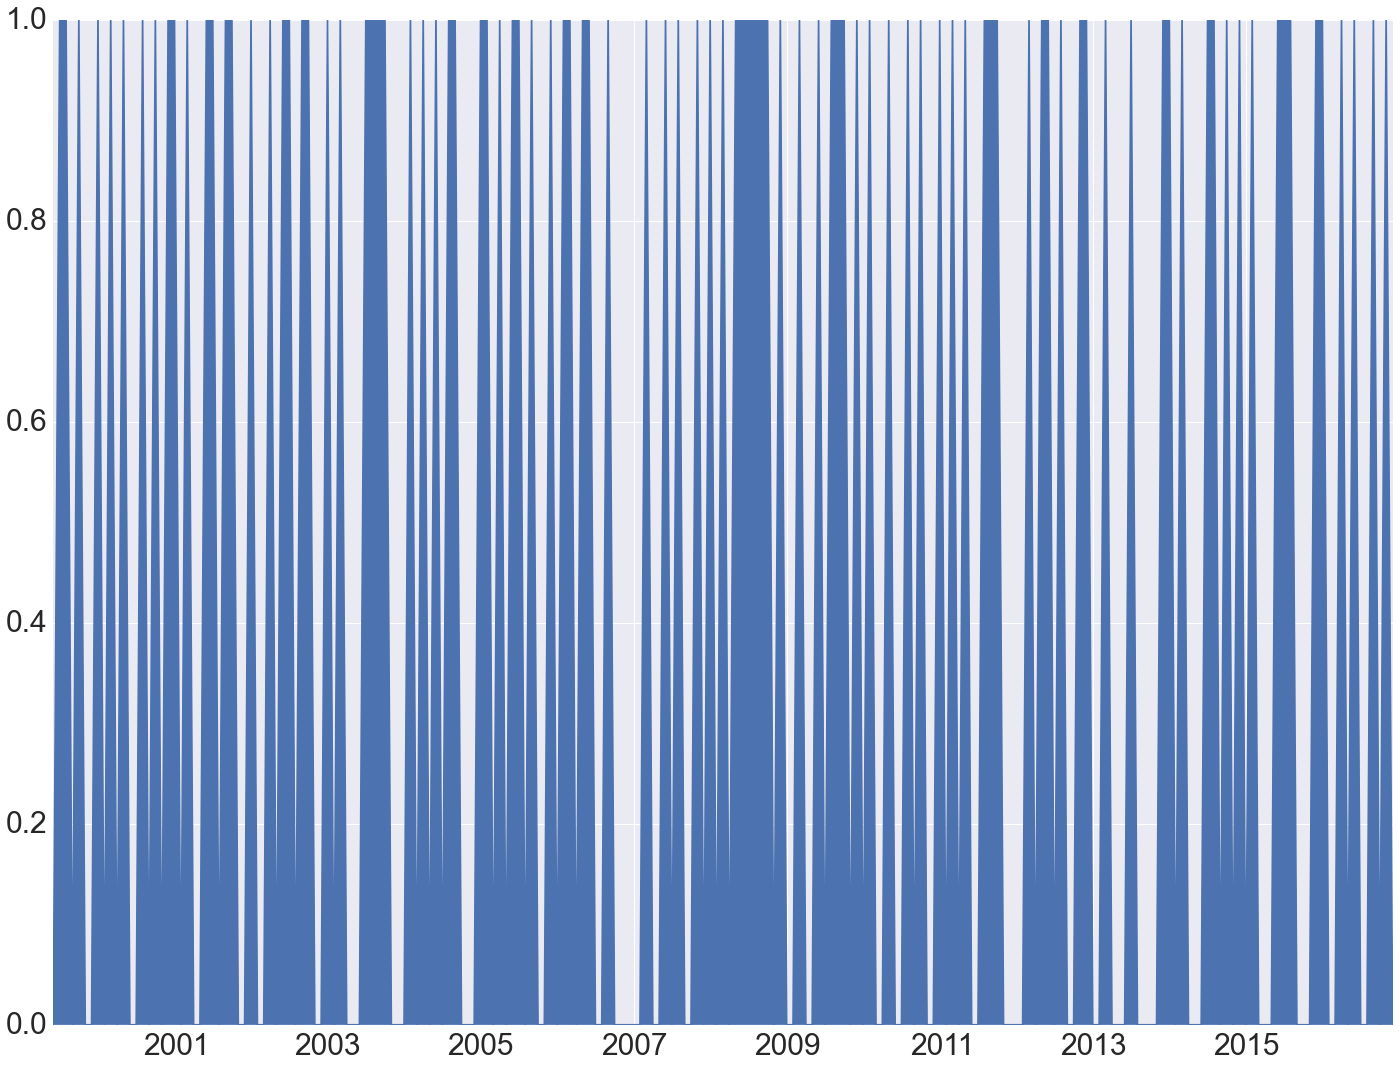

In [145]:
mkt_liquidity.plot(kind='area')

#Hedge Fund Index
* Can Amihud explain HF performance.  For example does increased liquidity reduce the amount of returns in hedge funds


In [146]:
mkt={
    'Eurekahedge Multi–Factor Risk Premia Index':'EUREKA/MEI27',
    'Eurekahedge CTA/Managed Futures Hedge Fund Index':'EUREKA/476',
    'Eurekahedge Macro Hedge Fund Index':'EUREKA/481',
    'Eurekahedge Trend Following Index':'EUREKA/647',
    'Eurekahedge Commodity Hedge Fund Index':'EUREKA/650'
}
index=pd.DataFrame()
for k,tick in mkt.items():
    index[k]=quandl.get(tick,authtoken=token).Returns

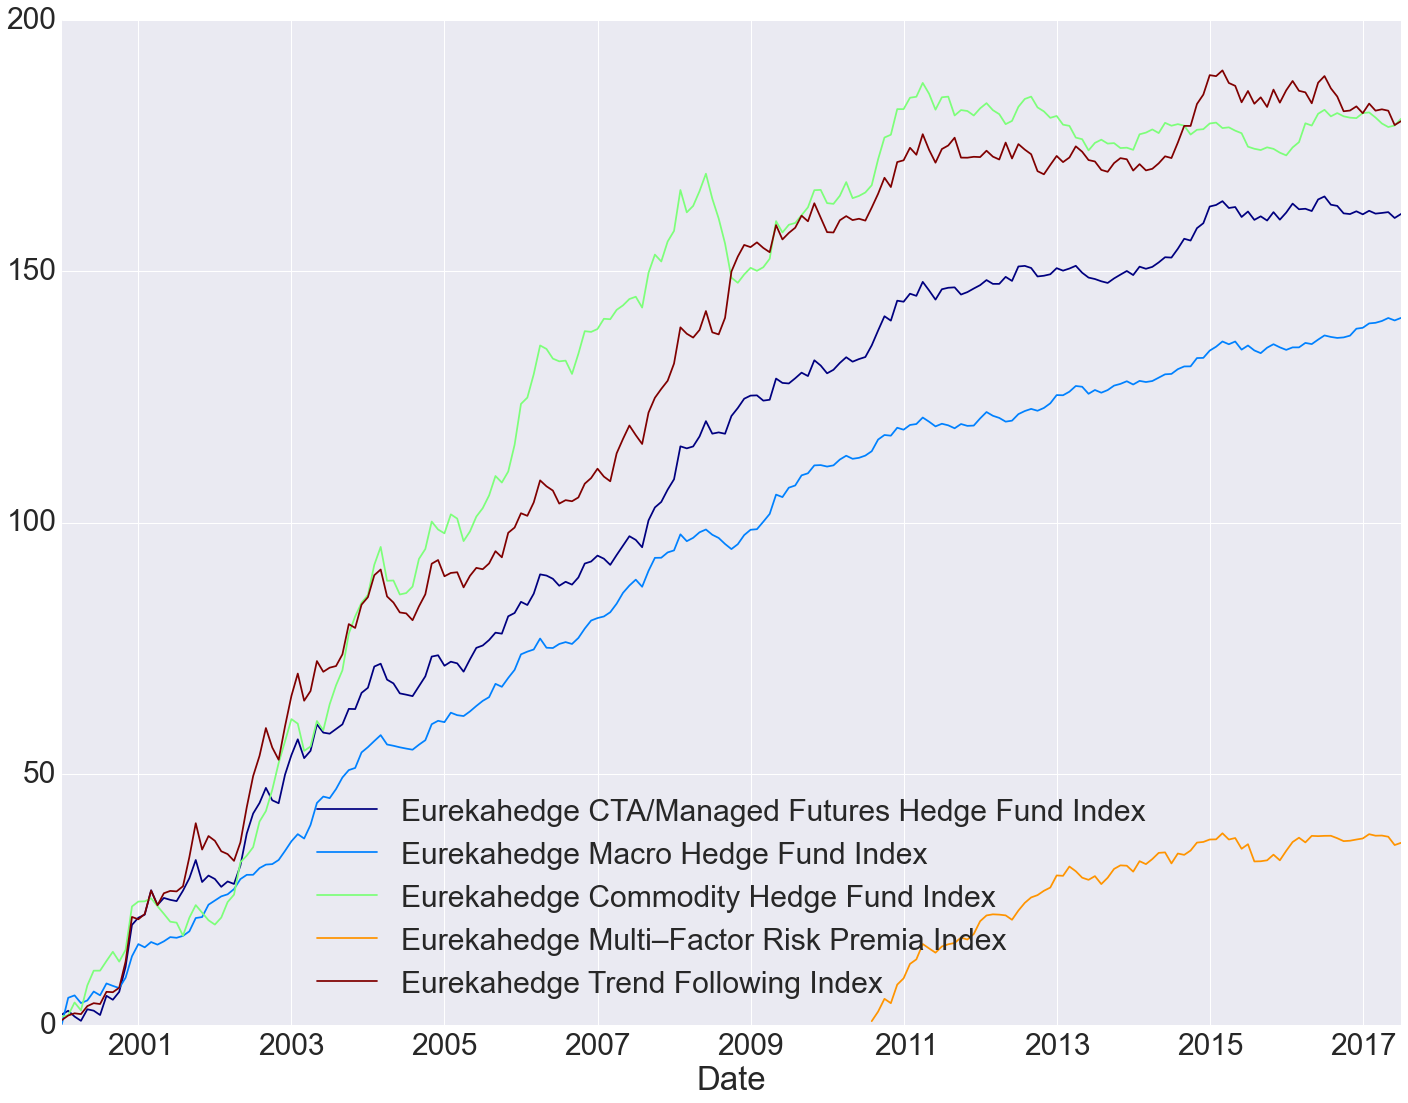

In [147]:
index.cumsum().plot(colormap='jet')

Added 6 month EWMA smoothing to get get higher results.  This deals with the attenuation bias in properly measuring liquidity risk.
* But I think this is cheating and not worth their time.  

In [148]:
index_rets=pd.ewma(index.pct_change(),6)
mkt_liquidity=pd.ewma(amihud.median(axis=1).dropna().diff(),6)
ind_res = pd.DataFrame()
for c in index.columns:
    s=pd.Series()
    ind=index_rets[c].dropna()[:'2016'].index
    ex=pd.DataFrame()
    ex['Amihud']=mkt_liquidity[ind]
    ex['Intercept']=1
    res=sm.OLS(index_rets[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Amihud/1e10']=res.params.Amihud/1e10
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res[c]=s

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=6).mean()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=6).mean()
  from IPython.kernel.zmq import kernelapp as app


In [149]:
ind_res.round(2)

,Eurekahedge CTA/Managed Futures Hedge Fund Index,Eurekahedge Macro Hedge Fund Index,Eurekahedge Commodity Hedge Fund Index,Eurekahedge Multi–Factor Risk Premia Index,Eurekahedge Trend Following Index
Intercept,5.12,-1.11,-1.54,-0.85,-4.32
Intercept Tstat,2.81,-1.27,-1.72,-3.96,-6.17
Amihud/1e10,120.85,-75.71,-135.56,-18.66,-40.28
Amihud Tstat,1.07,-1.40,-2.44,-0.31,-0.93
Adj R^2,0.00,0.00,0.02,-0.01,-0.00


In [150]:
FH_Trend=pd.read_csv('FH_Trend.csv',parse_dates=['Date'],index_col=0)
ind_res = pd.DataFrame()
ex=ex.join(FH_Trend)
for c in index.columns:
    s=pd.Series()
    ind=index[c].dropna()[:'2016'].index
    res=sm.OLS(index[c].dropna()[ind],ex.ix[ind]).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Amihud/1e9']=res.params.Amihud/1e9
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res[c]=s

LinAlgError: SVD did not converge

In [153]:
ind_res.round(2)

""


In [154]:
print ind_res.round(2).to_latex()

\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: Index([], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



# Including Fung and Hsieh HF factors
I want to understand residual alpha 

In [162]:
Factors=pd.read_csv('FH_Trend.csv',parse_dates=['Date'],index_col=0)
Factors['US10Y']=quandl.get('FED/RIFLGFCY10_N_M',authtoken=token).Value/100.

#Hedge Fund AUM
* Does increase in Hedge Fund AUM describe the rise of liquidity

Problems:
* We don't have great proxies for HFT shops

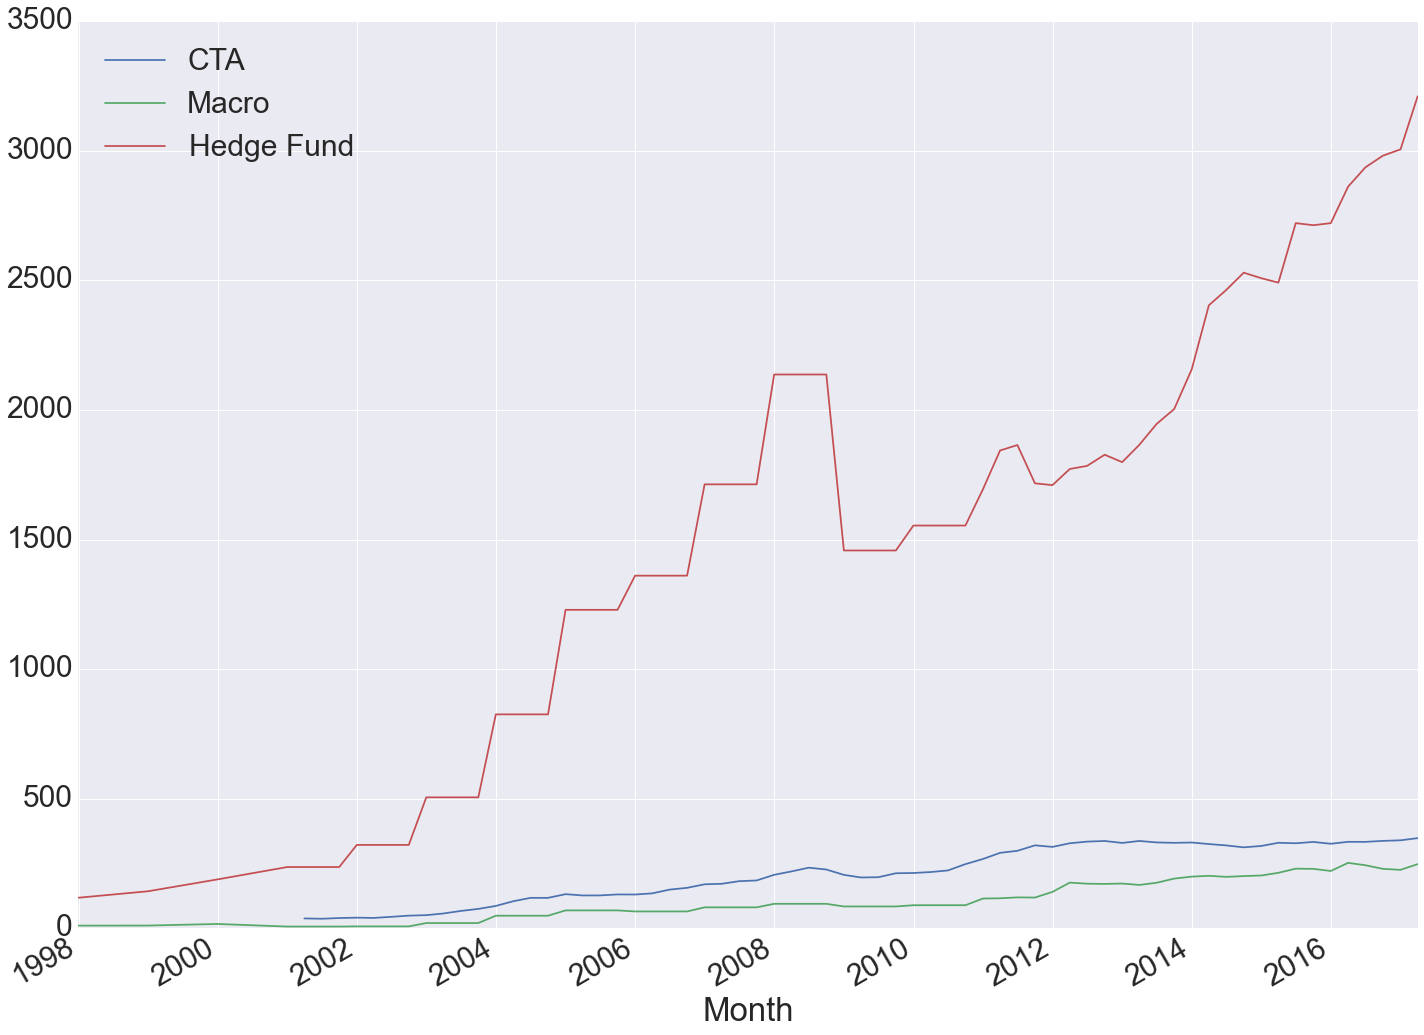

In [164]:
AUM=pd.read_csv('AUM.csv',parse_dates=['Month'],index_col=['Month'])
AUM.ffill().plot()

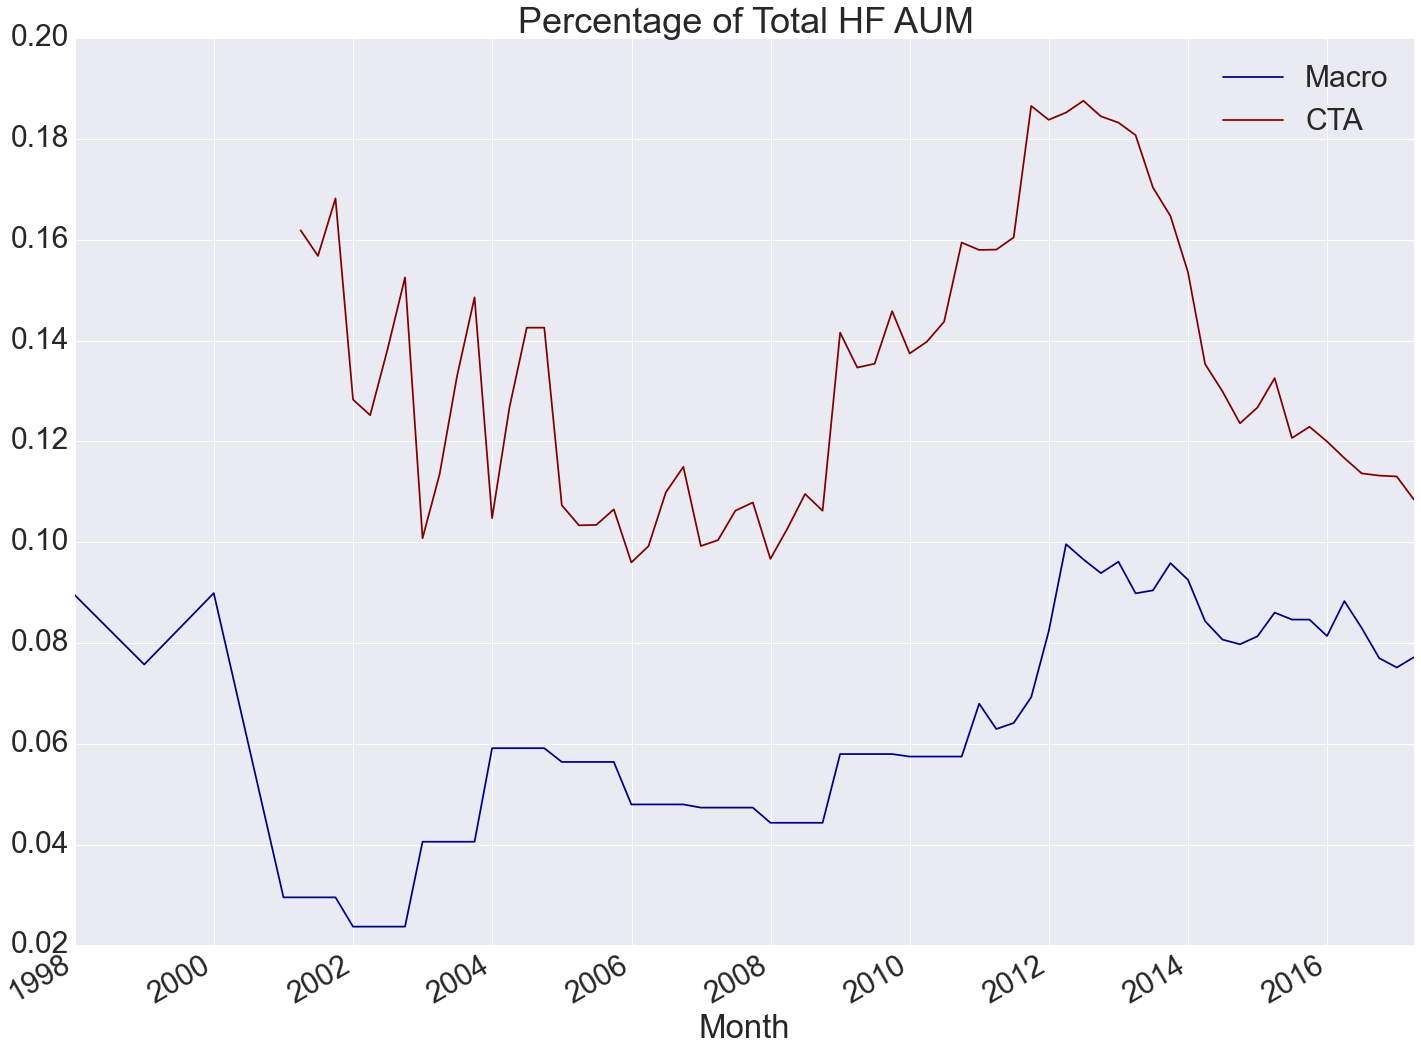

In [165]:
perc=pd.DataFrame()
perc['Macro']=AUM.Macro.ffill()/AUM['Hedge Fund'].ffill()
perc['CTA']=AUM.CTA/AUM['Hedge Fund'].ffill()
perc.plot(title='Percentage of Total HF AUM',stacked=False,colormap='jet')

# US 40 Act funds using CRSP Mutual Fund Database
* Can we use AUM of the funds to describe the increase in market liquidity
* Amihud and performance?  However, how far back does the 40 ACt fund goes

In [166]:
MF_data=pd.read_csv('MutualFund.csv',parse_dates=['caldt'])

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (5,11,31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [167]:
MF_data.columns

Index([u'summary_period2', u'crsp_fundno', u'caldt', u'nav_latest',
       u'nav_latest_dt', u'tna_latest', u'tna_latest_dt', u'yield', u'div_ytd',
       u'cap_gains_ytd', u'unrealized_app_dep', u'unrealized_app_dt',
       u'per_com', u'per_pref', u'per_conv', u'per_corp', u'per_muni',
       u'per_govt', u'per_oth', u'per_cash', u'per_bond', u'per_abs',
       u'per_mbs', u'maturity', u'crsp_cl_grp', u'fund_name', u'nasdaq',
       u'mgmt_name', u'mgr_name', u'inst_fund', u'index_fund_flag', u'et_flag',
       u'exp_ratio', u'mgmt_fee', u'turn_ratio', u'fiscal_yearend', u'policy',
       u'lipper_class', u'lipper_class_name', u'lipper_asset_cd'],
      dtype='object')

In [168]:
MF_data[MF_data.nasdaq=='AQMIX'].T

,473684,473685,473686,473687,473688,473689,473690
summary_period2,AQ,AQ,AQ,AQ,AQ,AQ,AQ
crsp_fundno,48695,48695,48695,48695,48695,48695,48695
caldt,2010-12-31 00:00:00,2011-12-30 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-30 00:00:00
nav_latest,10.3,9.57,9.78,10.59,10.63,10.18,9.32
nav_latest_dt,31/12/10,30/12/11,31/12/12,31/12/13,31/12/14,31/12/15,30/12/16
tna_latest,655.4,1081.1,2129.7,4497.2,5620.1,7777.1,7666
tna_latest_dt,31/12/10,30/12/11,31/12/12,31/12/13,31/12/14,31/12/15,30/12/16
yield,0.00850485,0.00401254,0.00764417,NaN,0.0449247,0.0448625,0.000175215
div_ytd,0.0876,0.0384,0.07476,NaN,0.47755,0.4567,0.001633
cap_gains_ytd,0.1496,0.0363,NaN,0.10739,0.49011,0.20628,NaN


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


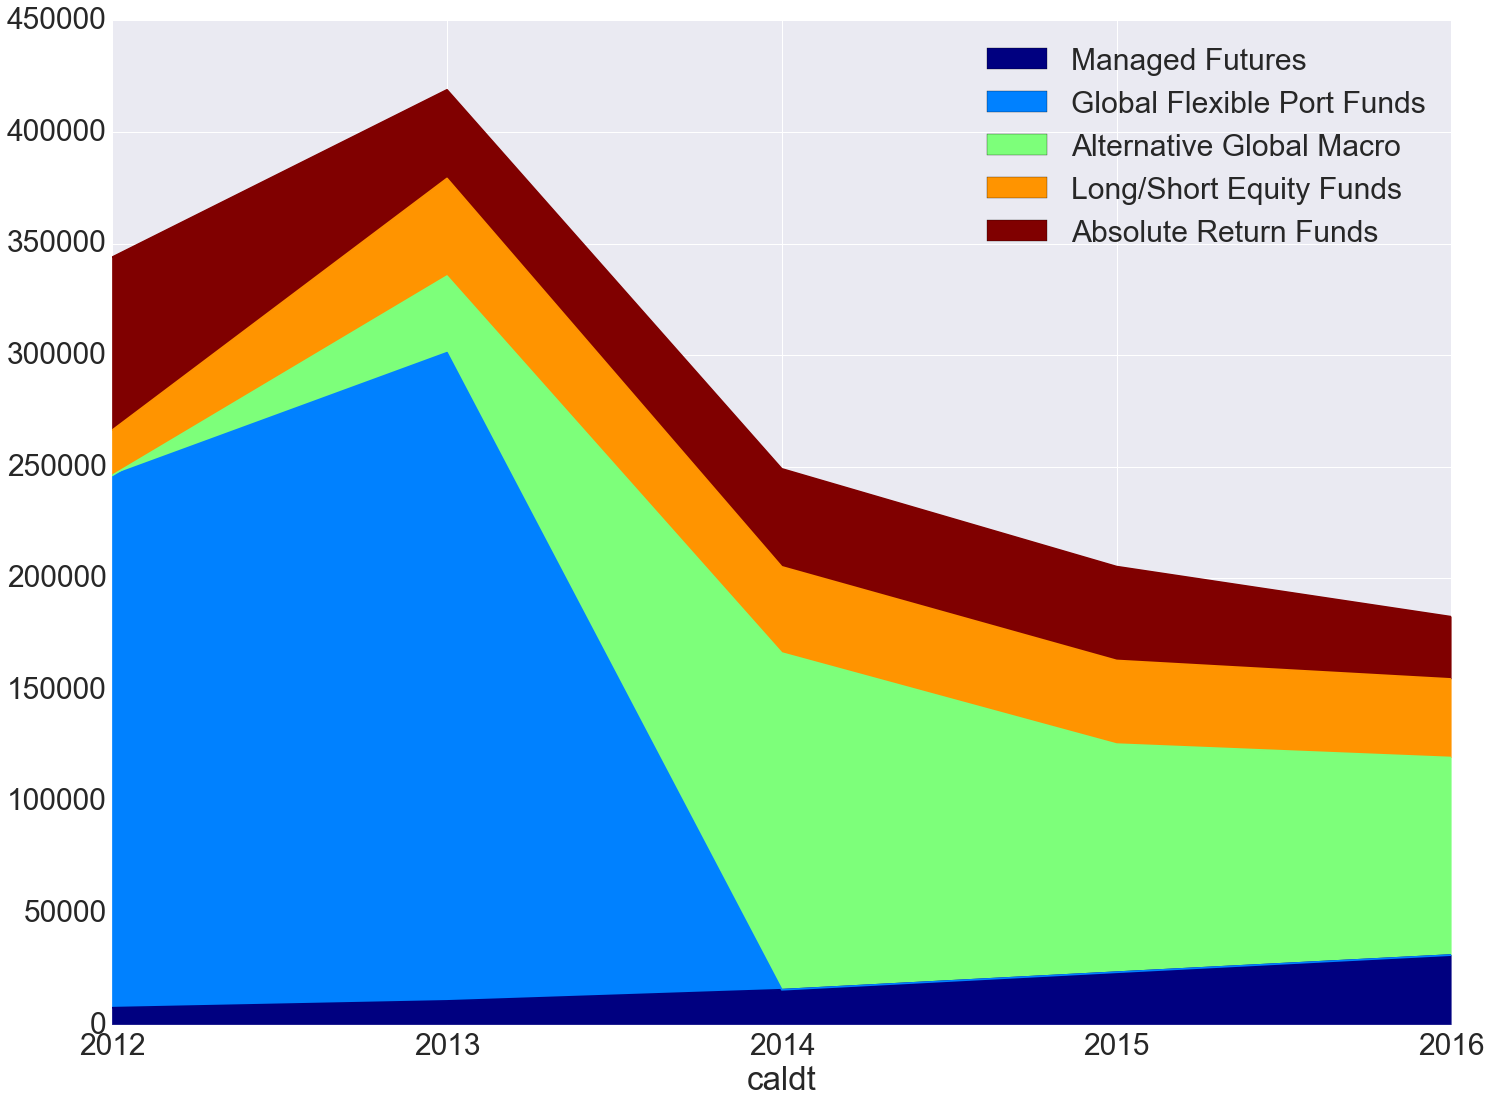

In [169]:
types={'Long/Short Equity Funds':'LSE',
       'Managed Futures':'MFF',
       'Absolute Return Funds':'ABR',
       'Alternative Global Macro':'AGM',
       'Global Flexible Port Funds':'GX'}
asset_alt=pd.DataFrame()
for k,tick in types.items():
    asset_alt[k]=MF_data[MF_data.lipper_class==tick].set_index('caldt').tna_latest.dropna(how='all').astype('float').resample(rule='m',how='sum').dropna()
asset_alt.plot(kind='area',colormap='jet',stacked=True)

In [170]:
x=MF_data[MF_data.lipper_class=='MFF']
no=x.crsp_fundno.unique()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


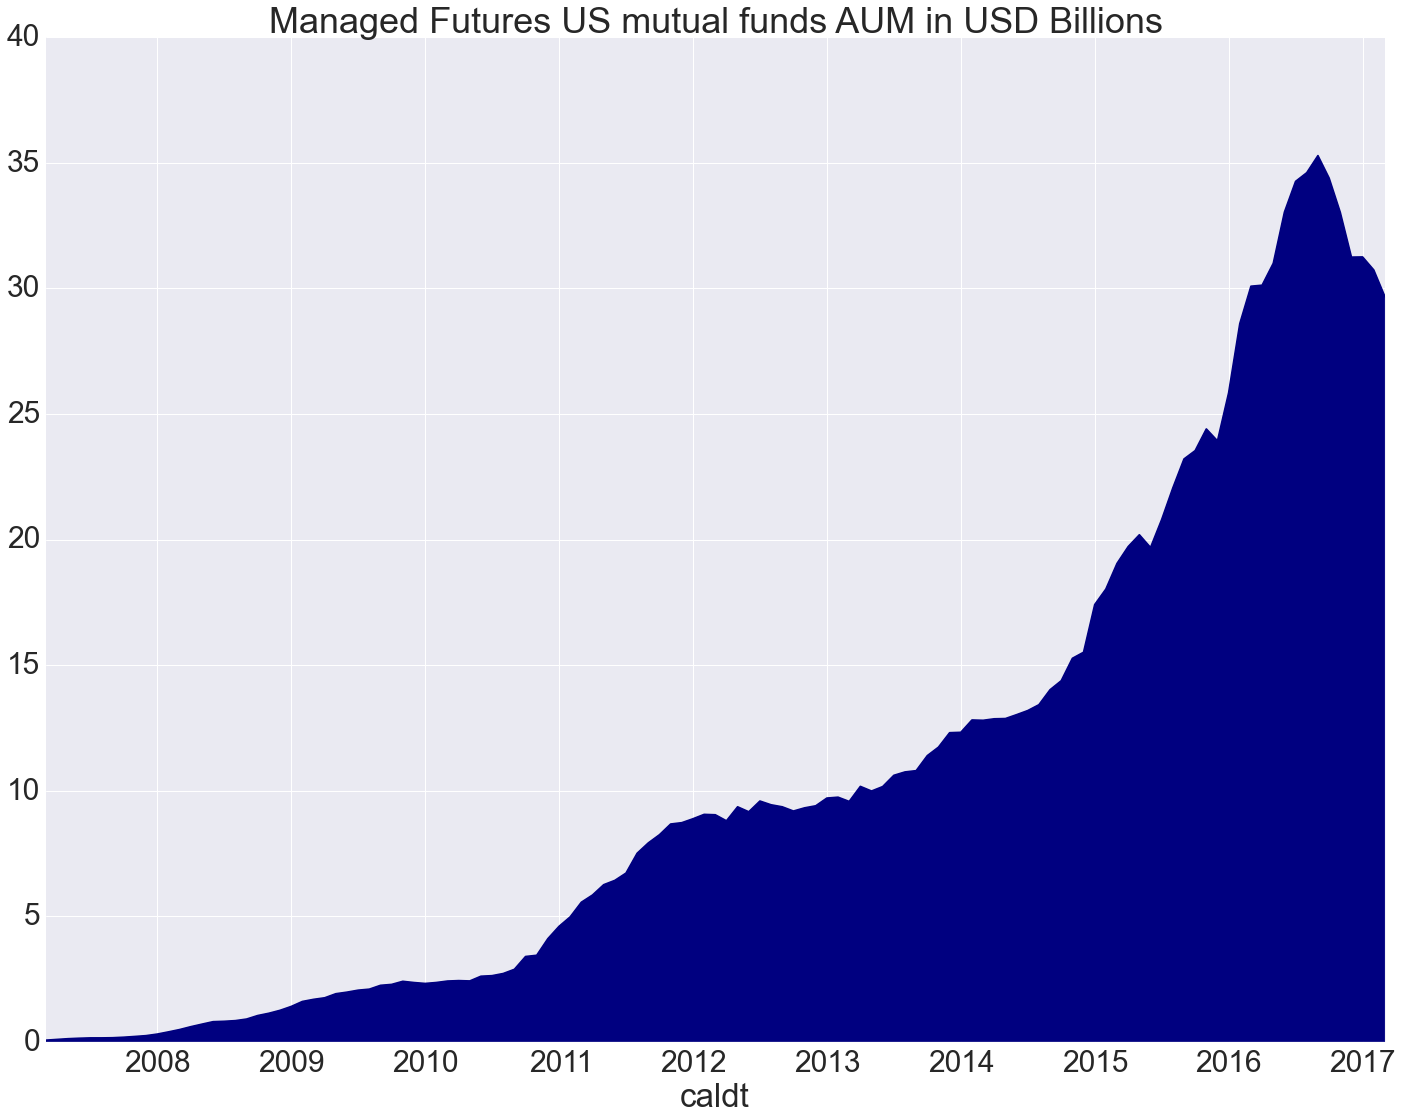

In [171]:
x=pd.read_csv('MF_Funds.csv',parse_dates=['caldt']).set_index('caldt').mtna.resample(rule='m',how='sum')
(x/1000).plot(kind='area',colormap='jet',title='Managed Futures US mutual funds AUM in USD Billions')

# Central Bank Assets


In [172]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [173]:
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


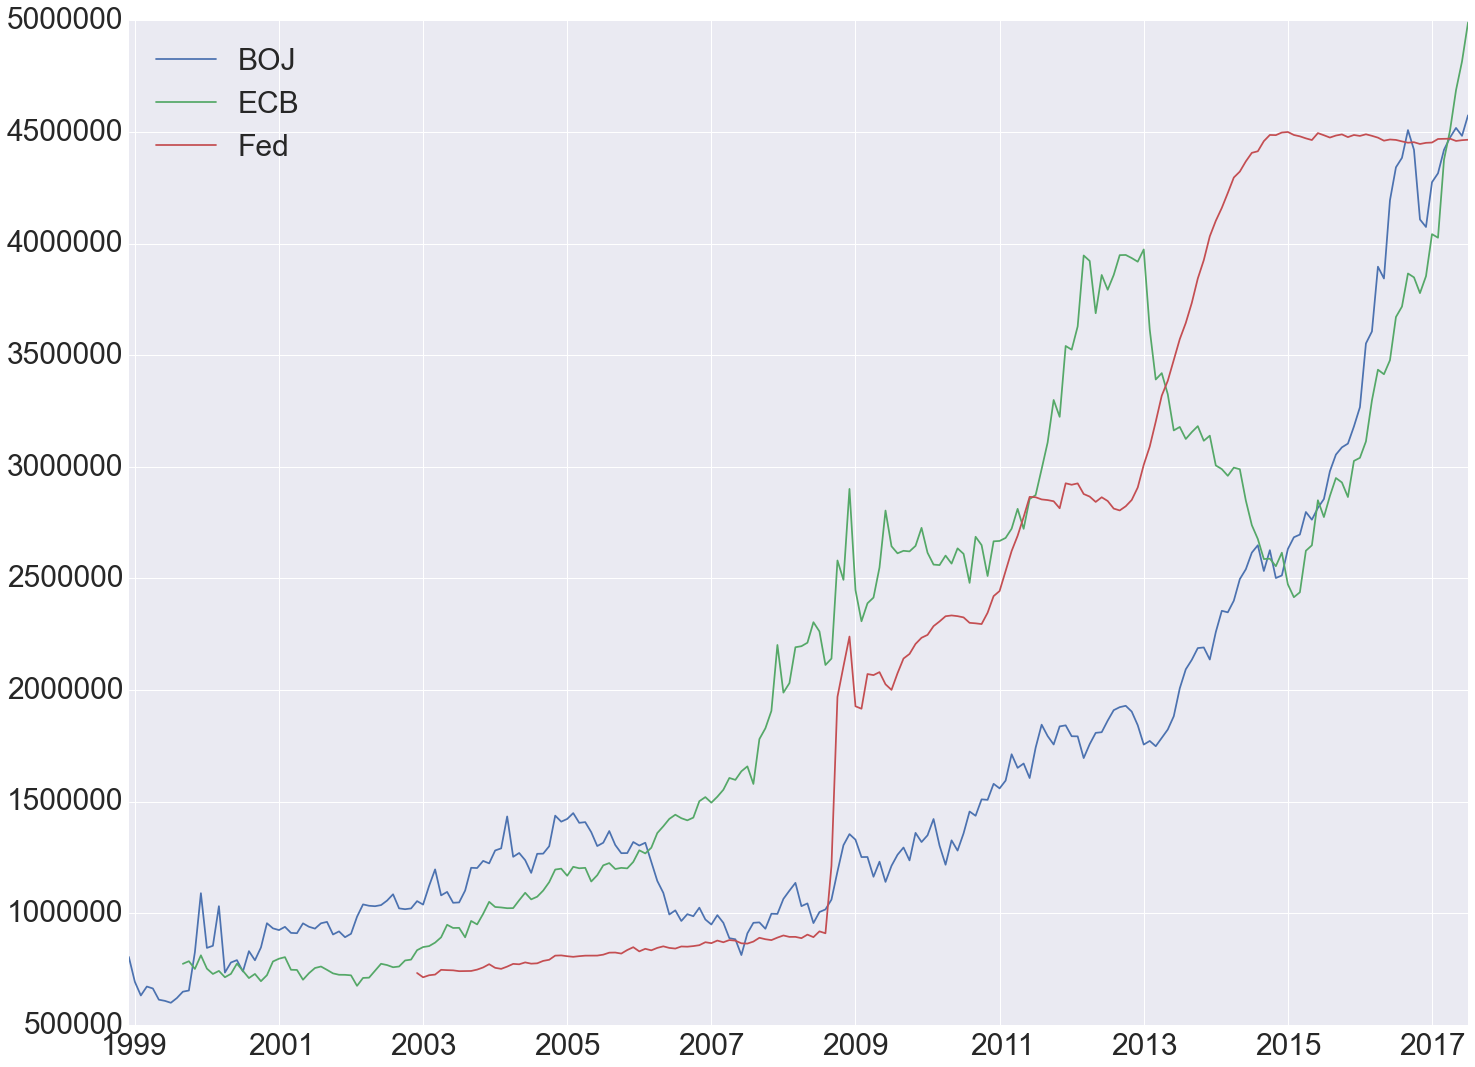

In [174]:
(central_banks_asset/fx).dropna(how='all').plot()

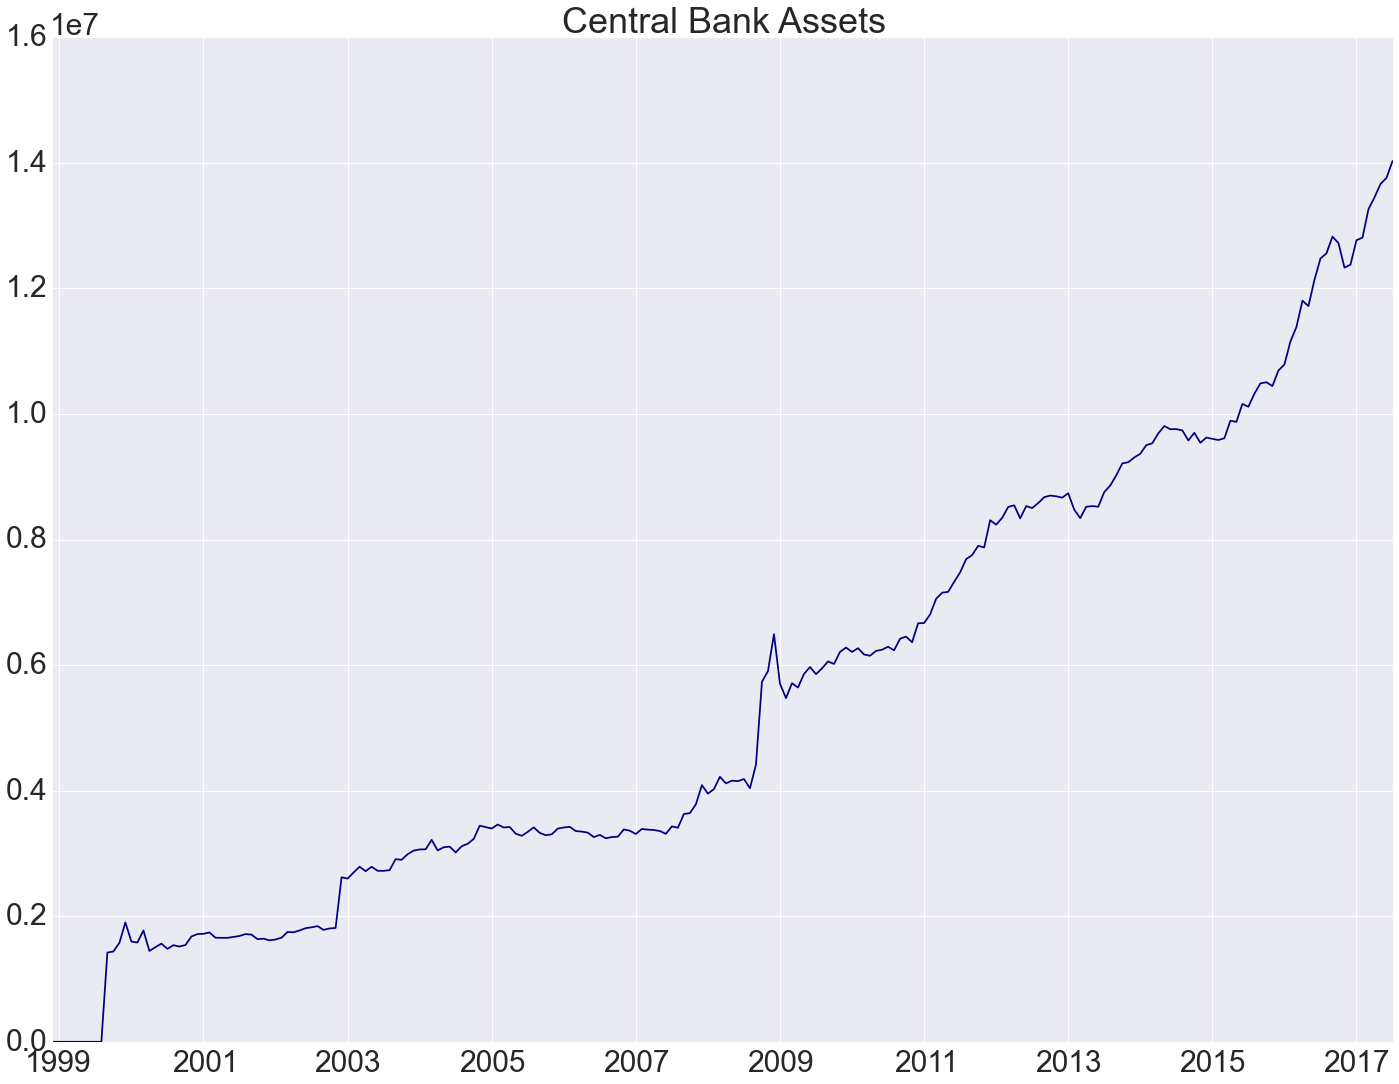

In [175]:
(central_banks_asset/fx.dropna())[:-1].sum(axis=1).plot(title='Central Bank Assets',colormap='jet')